# Utils 

In [1]:
def load_data(file_name):
    """ Loads the data.
    """
    npzfile = np.load(file_name)

    inputs_train = npzfile["inputs_train"].T / 255.0
    inputs_valid = npzfile["inputs_valid"].T / 255.0
    inputs_test = npzfile["inputs_test"].T / 255.0
    target_train = npzfile["target_train"].tolist()
    target_valid = npzfile["target_valid"].tolist()
    target_test = npzfile["target_test"].tolist()

    num_class = max(target_train + target_valid + target_test) + 1
    target_train_1hot = np.zeros([num_class, len(target_train)])
    target_valid_1hot = np.zeros([num_class, len(target_valid)])
    target_test_1hot = np.zeros([num_class, len(target_test)])

    for ii, xx in enumerate(target_train):
        target_train_1hot[xx, ii] = 1.0

    for ii, xx in enumerate(target_valid):
        target_valid_1hot[xx, ii] = 1.0

    for ii, xx in enumerate(target_test):
        target_test_1hot[xx, ii] = 1.0

    inputs_train = inputs_train.T
    inputs_valid = inputs_valid.T
    inputs_test = inputs_test.T
    target_train_1hot = target_train_1hot.T
    target_valid_1hot = target_valid_1hot.T
    target_test_1hot = target_test_1hot.T
    return inputs_train, inputs_valid, inputs_test, target_train_1hot, target_valid_1hot, target_test_1hot


def save(file_name, data):
    """ Saves the model to a numpy file.
    """
    print("Writing to " + file_name)
    np.savez_compressed(file_name, data)


def load(file_name):
    """ Loads the model from numpy file.
    """
    print("Loading from " + file_name)
    return dict(np.load(file_name))


def display_plot(train, valid, y_label, number=0):
    """ Displays training curve.
    :param train: Training statistics
    :param valid: Validation statistics
    :param y_label: Y-axis label of the plot
    :param number: The number of the plot
    :return: None
    """
    plt.figure(number)
    plt.clf()
    train = np.array(train)
    valid = np.array(valid)
    plt.plot(train[:, 0], train[:, 1], "b", label="Train")
    plt.plot(valid[:, 0], valid[:, 1], "g", label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel(y_label)
    plt.legend()
    plt.draw()
    plt.pause(0.0001)


# Load required libraries and datasets

In [2]:
import numpy as np
import matplotlib.pyplot as plt

inputs_train, inputs_valid, inputs_test, target_train, target_valid, \
        target_test = load_data("toronto_face.npz")

# NN Architecture 

In [3]:
""" Instruction:

In this section, you are asked to train a NN with different hyperparameters.
To start with training, you need to fill in the incomplete code. There are 3
places that you need to complete:
a) Backward pass equations for an affine layer (linear transformation + bias).
b) Backward pass equations for ReLU activation function.
c) Weight update equations.

After correctly fill in the code, modify the hyperparameters in "main()".
You can then run this file with the command: "python nn.py" in your terminal.
The program will automatically check your gradient implementation before start.
The program will print out the training progress, and it will display the
training curve by the end. You can optionally save the model by uncommenting
the lines in "main()".
"""


def init_nn(num_inputs, num_hiddens, num_outputs):
    """ Initializes neural network's parameters.
    :param num_inputs: Number of input units
    :param num_hiddens: List of two elements, hidden size for each layers.
    :param num_outputs: Number of output units
    :return: A dictionary of randomly initialized neural network weights.
    """
    W1 = 0.1 * np.random.randn(num_inputs, num_hiddens[0])
    W2 = 0.1 * np.random.randn(num_hiddens[0], num_hiddens[1])
    W3 = 0.01 * np.random.randn(num_hiddens[1], num_outputs)
    b1 = np.zeros((num_hiddens[0]))
    b2 = np.zeros((num_hiddens[1]))
    b3 = np.zeros((num_outputs))
    model = {
        "W1": W1,
        "W2": W2,
        "W3": W3,
        "b1": b1,
        "b2": b2,
        "b3": b3
    }
    return model


def affine(x, w, b):
    """ Computes the affine transformation.
    :param x: Inputs (or hidden layers)
    :param w: Weight
    :param b: Bias
    :return: Outputs
    """
    y = x.dot(w) + b
    return y


def relu(x):
    """ Computes the ReLU activation function.
    :param z: Inputs
    :return: Activation of x
    """
    return np.maximum(x, 0.0)


def softmax(x):
    """ Computes the softmax activation function.
    :param x: Inputs
    :return: Activation of x
    """
    return np.exp(x) / np.exp(x).sum(axis=1, keepdims=True)


def nn_forward(model, x):
    """ Runs a forward pass.
    :param model: Dictionary of all the weights.
    :param x: Input to the network.
    :return: Dictionary of all intermediate variables.
    """
    z1 = affine(x, model["W1"], model["b1"])
    h1 = relu(z1)
    z2 = affine(h1, model["W2"], model["b2"])
    h2 = relu(z2)
    y = affine(h2, model["W3"], model["b3"])
    var = {
        "x": x,
        "z1": z1,
        "h1": h1,
        "z2": z2,
        "h2": h2,
        "y": y
    }
    return var


def nn_backward(model, err, var):
    """ Runs the backward pass.
    :param model: Dictionary of all the weights.
    :param err: Gradients to the output of the network.
    :param var: Intermediate variables from the forward pass.
    :return: None
    """
    dE_dh2, dE_dW3, dE_db3 = affine_backward(err, var["h2"], model["W3"])
    dE_dz2 = relu_backward(dE_dh2, var["z2"])
    dE_dh1, dE_dW2, dE_db2 = affine_backward(dE_dz2, var["h1"], model["W2"])
    dE_dz1 = relu_backward(dE_dh1, var["z1"])
    _, dE_dW1, dE_db1 = affine_backward(dE_dz1, var["x"], model["W1"])
    model["dE_dW1"] = dE_dW1
    model["dE_dW2"] = dE_dW2
    model["dE_dW3"] = dE_dW3
    model["dE_db1"] = dE_db1
    model["dE_db2"] = dE_db2
    model["dE_db3"] = dE_db3
    return


def train(model, forward, backward, update, eta, num_epochs, batch_size):
    """ Trains a simple MLP.
    :param model: Dictionary of model weights.
    :param forward: Forward prop function.
    :param backward: Backward prop function.
    :param update: Update weights function.
    :param eta: Learning rate.
    :param num_epochs: Number of epochs to run training for.
    :param batch_size: Mini-batch size, -1 for full batch.
    :return: A tuple (train_ce, valid_ce, train_acc, valid_acc)
        WHERE
        train_ce: Training cross entropy.
        valid_ce: Validation cross entropy.
        train_acc: Training accuracy.
        valid_acc: Validation accuracy.
    """
    inputs_train, inputs_valid, inputs_test, target_train, target_valid, \
        target_test = load_data("toronto_face.npz")
    rnd_idx = np.arange(inputs_train.shape[0])
    
    train_ce_list = []
    valid_ce_list = []
    train_acc_list = []
    valid_acc_list = []
    num_train_cases = inputs_train.shape[0]
    if batch_size == -1:
        batch_size = num_train_cases
    num_steps = int(np.ceil(num_train_cases / batch_size))
    for epoch in range(num_epochs):
        np.random.shuffle(rnd_idx)
        inputs_train = inputs_train[rnd_idx]
        target_train = target_train[rnd_idx]
        for step in range(num_steps):
            # Forward pass.
            start = step * batch_size
            end = min(num_train_cases, (step + 1) * batch_size)
            x = inputs_train[start: end]
            t = target_train[start: end]

            var = forward(model, x)
            prediction = softmax(var["y"])

            train_ce = -np.sum(t * np.log(prediction)) / float(x.shape[0])
            train_acc = (np.argmax(prediction, axis=1) ==
                         np.argmax(t, axis=1)).astype("float").mean()
            # print(("Epoch {:3d} Step {:2d} Train CE {:.5f} "
            #        "Train Acc {:.5f}").format(
            #     epoch, step, train_ce, train_acc))

            # Compute error.
            error = (prediction - t) / float(x.shape[0])

            # Backward prop.
            backward(model, error, var)

            # Update weights.
            update(model, eta)

        valid_ce, valid_acc = evaluate(
            inputs_valid, target_valid, model, forward, batch_size=batch_size)
        # print(("Epoch {:3d} "
        #        "Validation CE {:.5f} "
        #        "Validation Acc {:.5f}\n").format(
        #     epoch, valid_ce, valid_acc))
        train_ce_list.append((epoch, train_ce))
        train_acc_list.append((epoch, train_acc))
        valid_ce_list.append((epoch, valid_ce))
        valid_acc_list.append((epoch, valid_acc))
    display_plot(train_ce_list, valid_ce_list, "Cross Entropy", number=0)
    display_plot(train_acc_list, valid_acc_list, "Accuracy", number=1)

    train_ce, train_acc = evaluate(
        inputs_train, target_train, model, forward, batch_size=batch_size)
    valid_ce, valid_acc = evaluate(
        inputs_valid, target_valid, model, forward, batch_size=batch_size)
    test_ce, test_acc = evaluate(
        inputs_test, target_test, model, forward, batch_size=batch_size)
    print("CE: Train %.5f Validation %.5f Test %.5f" %
          (train_ce, valid_ce, test_ce))
    print("Acc: Train {:.5f} Validation {:.5f} Test {:.5f}".format(
        train_acc, valid_acc, test_acc))

    stats = {
        "train_ce": train_ce_list,
        "valid_ce": valid_ce_list,
        "train_acc": train_acc_list,
        "valid_acc": valid_acc_list
    }

    return model, stats


def evaluate(inputs, target, model, forward, batch_size=-1):
    """ Evaluates the model on inputs and target.
    :param inputs: Inputs to the network
    :param target: Target of the inputs
    :param model: Dictionary of network weights
    :param forward: Function for forward pass
    :param batch_size: Batch size
    :return: A tuple (ce, acc)
        WHERE
        ce: cross entropy
        acc: accuracy
    """
    num_cases = inputs.shape[0]
    if batch_size == -1:
        batch_size = num_cases
    num_steps = int(np.ceil(num_cases / batch_size))
    ce = 0.0
    acc = 0.0
    for step in range(num_steps):
        start = step * batch_size
        end = min(num_cases, (step + 1) * batch_size)
        x = inputs[start: end]
        t = target[start: end]
        prediction = softmax(forward(model, x)["y"])
        ce += -np.sum(t * np.log(prediction))
        acc += (np.argmax(prediction, axis=1) == np.argmax(
            t, axis=1)).astype("float").sum()
    ce /= num_cases
    acc /= num_cases
    return ce, acc


def check_grad(model, forward, backward, name, x):
    """ Check the gradients.
    """
    np.random.seed(0)
    var = forward(model, x)
    loss = lambda y: 0.5 * (y ** 2).sum()
    grad_y = var["y"]
    backward(model, grad_y, var)
    grad_w = model["dE_d" + name].ravel()
    w_ = model[name].ravel()
    eps = 1e-7
    grad_w_2 = np.zeros(w_.shape)
    check_elem = np.arange(w_.size)
    np.random.shuffle(check_elem)
    # Randomly check 20 elements.
    check_elem = check_elem[:20]
    for ii in check_elem:
        w_[ii] += eps
        err_plus = loss(forward(model, x)["y"])
        w_[ii] -= 2 * eps
        err_minus = loss(forward(model, x)["y"])
        w_[ii] += eps
        grad_w_2[ii] = (err_plus - err_minus) / 2. / eps
    np.testing.assert_almost_equal(grad_w[check_elem], grad_w_2[check_elem],
                                   decimal=3)


# Functions

In [4]:
def affine_backward(grad_y, x, w):
    """ Computes gradients of affine transformation.
    Hint: you may need the matrix transpose np.dot(A, B).T = np.dot(B, A) and (A.T).T = A
    :param grad_y: Gradient from upper layer
    :param x: Inputs from the hidden layer
    :param w: Weights
    :return: A tuple of (grad_h, grad_w, grad_b)
        WHERE
        grad_x: Gradients wrt. the inputs/hidden layer.
        grad_w: Gradients wrt. the weights.
        grad_b: Gradients wrt. the biases.
    """
    #####################################################################
    # TODO:                                                             #
    # Complete the function to compute the gradients of affine          #
    # transformation.                                                   #
    #####################################################################
    grad_x = None
    grad_w = None
    grad_b = None

    dim = np.prod(x[0].shape)
    X = x.reshape(x.shape[0], dim)

    grad_x = np.dot(grad_y, w.T).reshape(x.shape)
    grad_w = np.dot(X.T, grad_y)

    grad_b = np.sum(grad_y, axis=0)
    #####################################################################
    #                       END OF YOUR CODE                            #
    #####################################################################
    return grad_x, grad_w, grad_b


In [5]:
def relu_backward(grad_y, x):
    """ Computes gradients of the ReLU activation function wrt. the unactivated inputs.
    :param grad_y: Gradient of the activation.
    :param x: Inputs
    :return: Gradient wrt. x
    """
    #####################################################################
    # TODO:                                                             #
    # Complete the function to compute the gradients of relu.           #
    #####################################################################
    grad_x = (x > 0) * grad_y
    #####################################################################
    #                       END OF YOUR CODE                            #
    #####################################################################
    return grad_x

In [6]:
def nn_update(model, eta):
    """ Update NN weights.
    :param model: Dictionary of all the weights.
    :param eta: Learning rate
    :return: None
    """
    #####################################################################
    # TODO:                                                             #
    # Complete the function to update the neural network's parameters.  #
    # Your code should look as follows                                  #
    # model["W1"] = ...                                                 #
    # model["W2"] = ...                                                 #
    # ...                                                               #
    #####################################################################
    model["W1"] -= eta * model["dE_dW1"]
    model["W2"] -= eta * model["dE_dW2"]
    model["W3"] -= eta * model["dE_dW3"]
    model["b1"] -= eta * model["dE_db1"]
    model["b2"] -= eta * model["dE_db2"]
    model["b3"] -= eta * model["dE_db3"]
    #####################################################################
    #                       END OF YOUR CODE                            #
    #####################################################################
    return

In [7]:
def main():
    """ Trains a neural network.
    :return: None
    """
    model_file_name = "nn_model.npz"
    stats_file_name = "nn_stats.npz"

    # Hyper-parameters. Modify them if needed.
    num_hiddens = [16, 32]
    eta = 0.01
    num_epochs = 1000 # Number of iterations
    batch_size = 100

    # Input-output dimensions.
    num_inputs = 2304
    num_outputs = 7

    # Initialize model.
    model = init_nn(num_inputs, num_hiddens, num_outputs)

    # Uncomment to reload trained model here.
    # model = load(model_file_name)

    # Check gradient implementation.
    print("Checking gradients...")
    x = np.random.rand(10, 48 * 48) * 0.1
    check_grad(model, nn_forward, nn_backward, "W3", x)
    check_grad(model, nn_forward, nn_backward, "b3", x)
    check_grad(model, nn_forward, nn_backward, "W2", x)
    check_grad(model, nn_forward, nn_backward, "b2", x)
    check_grad(model, nn_forward, nn_backward, "W1", x)
    check_grad(model, nn_forward, nn_backward, "b1", x)

    # Train model.
    stats = train(model, nn_forward, nn_backward, nn_update, eta,
                  num_epochs, batch_size)

    # Uncomment if you wish to save the model.
    # save(model_file_name, model)

    # Uncomment if you wish to save the training statistics.
    # save(stats_file_name, stats)


In [8]:
def train_different_eta(eta_input):
    # model_file_name = "nn_model.npz"
    # stats_file_name = "nn_stats.npz"

    # Hyper-parameters. Modify them if needed.
    num_hiddens = [16, 32]
    num_epochs = 1000 # Number of iterations
    batch_size = 100

    # Input-output dimensions.
    num_inputs = 2304
    num_outputs = 7

    # Initialize model.
    model_eta = init_nn(num_inputs, num_hiddens, num_outputs)
    stats_eta = train(model_eta, nn_forward, nn_backward, nn_update, eta_input,
                      num_epochs, batch_size)


def train_different_batch(batch_input):
    # model_file_name = "nn_model.npz"
    # stats_file_name = "nn_stats.npz"

    # Hyper-parameters. Modify them if needed.
    num_hiddens = [16, 32]
    eta = 0.01
    num_epochs = 1000 # Number of iterations

    # Input-output dimensions.
    num_inputs = 2304
    num_outputs = 7

    # Initialize model.
    model_batch = init_nn(num_inputs, num_hiddens, num_outputs)
    stats_batch = train(model_batch, nn_forward, nn_backward, nn_update, eta,
                      num_epochs, batch_input)


def train_different_hiddens(num_hiddens):
    # model_file_name = "nn_model.npz"
    # stats_file_name = "nn_stats.npz"

    # Hyper-parameters. Modify them if needed.
    num_hiddens = [16, 32]
    eta = 0.01
    num_epochs = 1000 # Number of iterations
    batch_size = 100

    # Input-output dimensions.
    num_inputs = 2304
    num_outputs = 7

    # Initialize model.
    model_hidden = init_nn(num_inputs, num_hiddens, num_outputs)

    # Train model.
    stats_hidden = train(model_hidden, nn_forward, nn_backward, nn_update, eta,
                  num_epochs, batch_size)


# Generalization


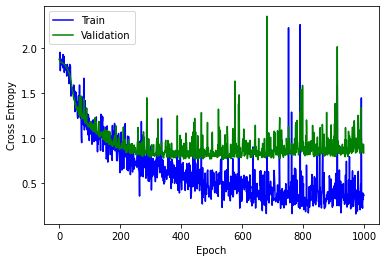

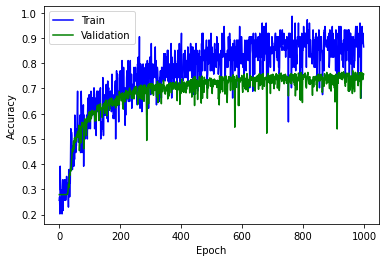

CE: Train 0.27820 Validation 0.83641 Test 0.83629
Acc: Train 0.90575 Validation 0.75656 Test 0.72208


In [9]:
# default hyperparameters
# Hyper-parameters. Modify them if needed.
num_hiddens = [16, 32]
eta = 0.01
num_epochs = 1000 # Number of iterations
batch_size = 100

# Input-output dimensions.
num_inputs = 2304
num_outputs = 7

# Initialize model.
default_model = init_nn(num_inputs, num_hiddens, num_outputs)

# Uncomment to reload trained model here.
# model = load(default_model)

# Train model.
stats = train(default_model, nn_forward, nn_backward, nn_update, eta,
                num_epochs, batch_size)

# save(default_model, default_model)

Using the default parameters, we observe that for both training and validation entropy decrease as epoch increases. This is due to backpropagation. 

Notice that the validation cross entropy has been slightly increasing since the epoch size of 400, since backpropagation has been tuning the weights during forward and backward passes. This might be an indication of overfitting. 

# Optimization
Different values of the learning rate (step size) η (“eta”) ranging from η ∈ {0.001, 0.01, 0.5}. We discover the convergence properties of the algorithm (looking at both cross-entropy and percent-correct) by trying 3 different mini-batch sizes ranging from {10,100,1000}.

Using $\eta\in\{0.001, 0.01, 0.5\}$

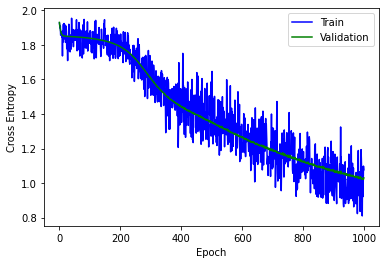

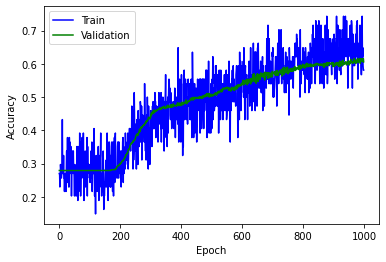

CE: Train 1.00777 Validation 1.03045 Test 1.05981
Acc: Train 0.63456 Validation 0.60621 Test 0.57143


In [10]:
# eta = 0.001
train_different_eta(0.001)

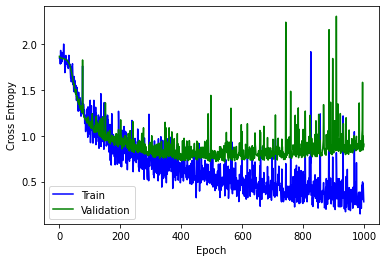

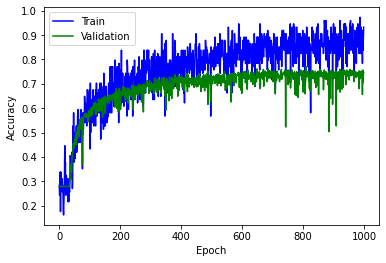

CE: Train 0.32169 Validation 0.90943 Test 0.77973
Acc: Train 0.88085 Validation 0.74702 Test 0.76364


In [11]:
# eta = 0.01
train_different_eta(0.01)

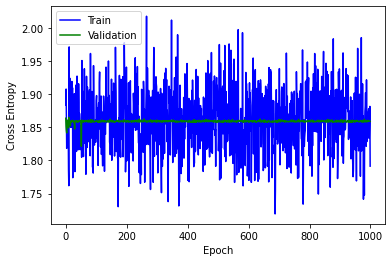

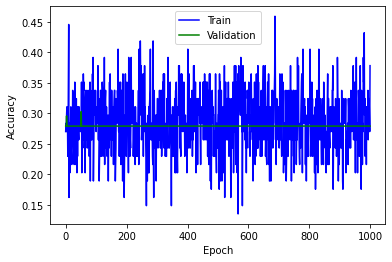

CE: Train 1.86095 Validation 1.85911 Test 1.83831
Acc: Train 0.28542 Validation 0.27924 Test 0.31688


In [12]:
# eta = 0.5
train_different_eta(0.5)

In this part, we picked $\eta\in\{0.001, 0.01, 0.5\}$, while keeping all other parameters (mini-batch size, etc) default.

We observe that the variances are high when learning rate is high, due to bias-variance trade-offs.

Also observe that cross entropy converges faster as $\eta$ increases. This is obvious when $\eta=0.5$: from the plot it converges since the the beginning.

Using mini-batch sizes from $\{10, 100, 1000\}$

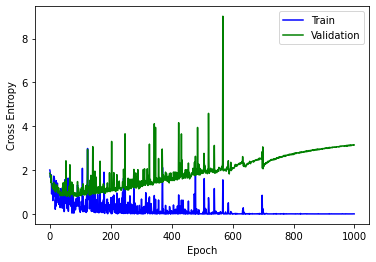

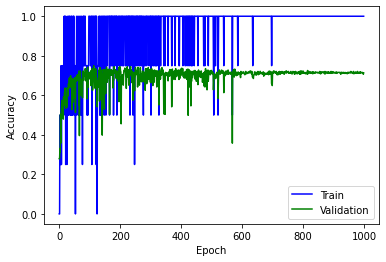

CE: Train 0.00089 Validation 3.14490 Test 2.09666
Acc: Train 1.00000 Validation 0.71360 Test 0.75325


In [13]:
# Mini-batch size 10
train_different_batch(10)

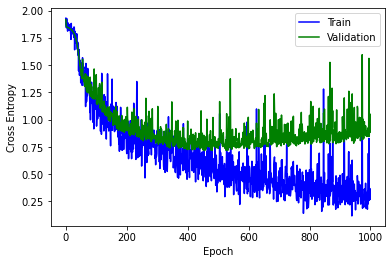

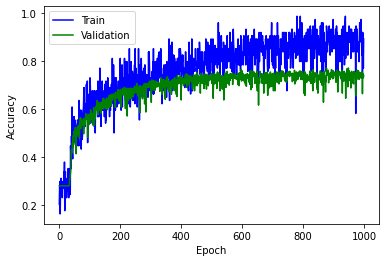

CE: Train 0.28882 Validation 0.88453 Test 0.78666
Acc: Train 0.90130 Validation 0.73986 Test 0.74545


In [14]:
# Mini-batch size 100
train_different_batch(100)

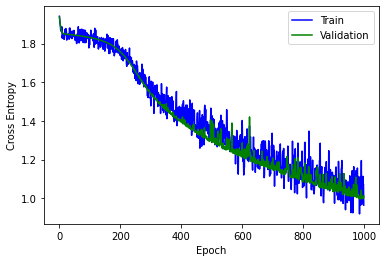

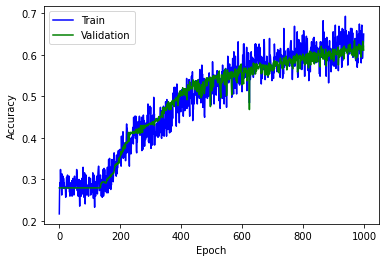

CE: Train 1.04708 Validation 1.01092 Test 1.09691
Acc: Train 0.62626 Validation 0.61098 Test 0.57403


In [15]:
# Mini-batch size 1000
train_different_batch(1000)

In this part, we pick mini-batch sizes from $\{10, 100, 1000\}$, while keeping other parameters default (from `nn.py`).

Notice that for large batch sizes, training entropy is close to validation entropy, and training accuracy is close to validation accuracy; for small batch sizes, the variance is higher: this is obvious from the plot of batch size 10. We conclude that variance decreases as batch size increases.

To pick ideal batch size, we can start from small size and gradually increase it , until the cross entropy and accuracy both converge. Then, we keep tuning it until we find an optimized point (minimum entropy and maximum accuracy).

# Model Architecture

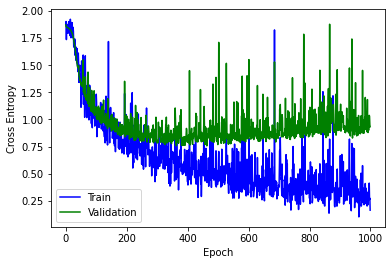

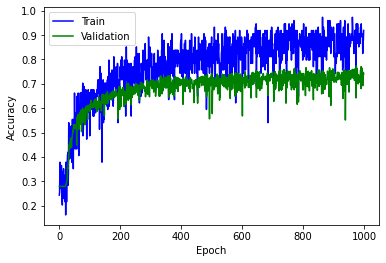

CE: Train 0.26113 Validation 0.93216 Test 0.77729
Acc: Train 0.90664 Validation 0.73986 Test 0.73766


In [16]:
# Hidden size [2, 32]
train_different_hiddens([2, 32])

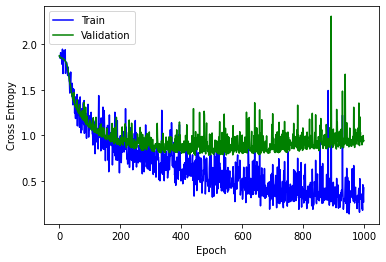

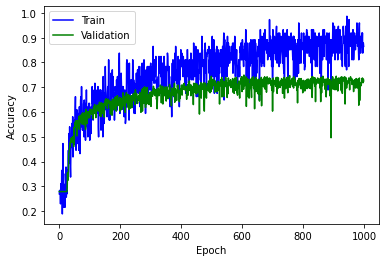

CE: Train 0.31989 Validation 0.94103 Test 0.74438
Acc: Train 0.88204 Validation 0.72554 Test 0.76364


In [17]:
# Hidden size [20, 32]
train_different_hiddens([20, 32])

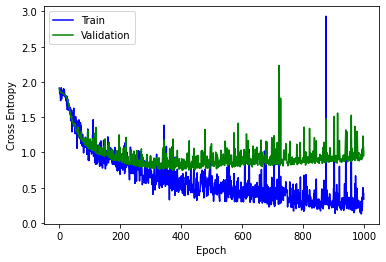

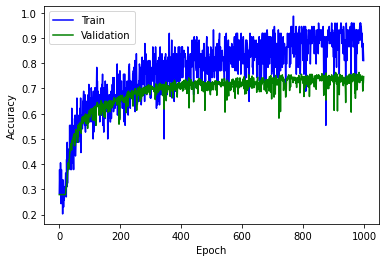

CE: Train 0.26571 Validation 0.95466 Test 0.82779
Acc: Train 0.90456 Validation 0.74702 Test 0.73506


In [18]:
# Hidden size [80, 32]
train_different_hiddens([80, 32])

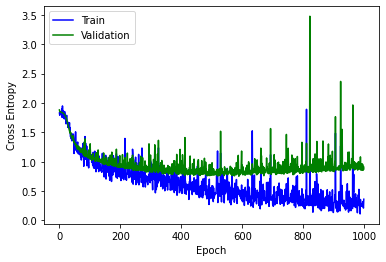

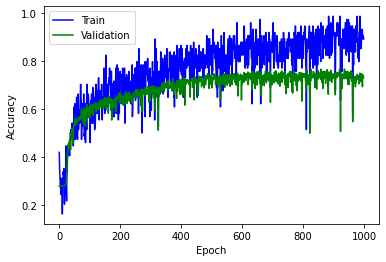

CE: Train 0.29704 Validation 0.87541 Test 0.78721
Acc: Train 0.89834 Validation 0.73031 Test 0.77143


In [19]:
# Hidden size [16, 2]
train_different_hiddens([16, 2])

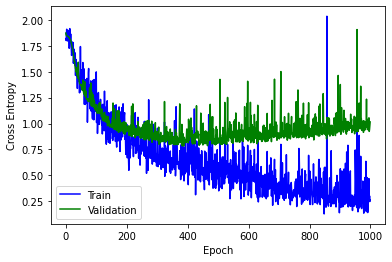

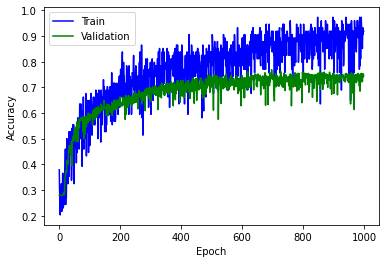

CE: Train 0.25008 Validation 1.01569 Test 0.85888
Acc: Train 0.91108 Validation 0.74463 Test 0.73247


In [20]:
# Hidden size [16, 20]
train_different_hiddens([16, 20])

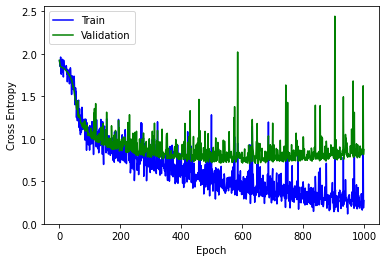

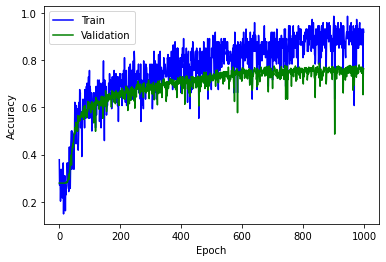

CE: Train 0.30700 Validation 0.87247 Test 0.86873
Acc: Train 0.88530 Validation 0.76372 Test 0.72727


In [21]:
# Hidden size [16, 80]
train_different_hiddens([16, 80])

We observe that large size of the hidden layers results in better accuracy: but this is potentially overfitting, since generalization will be poor for such model with high capacity. We should avoid picking large size for hidden layers as it works poorly on general datasets.

We can pick size of hidden layers to be the size of labels initially. Additionally, we can do regularization to avoid overfitting.

# Network Uncertainty

We define function to plot 5 unconfident images:

In [24]:
classes = ["anger", "disgust", "fear", "happy", "sad", "surprised", "neutral"]

def plot_uncertain(x, t, model, threshold):
    num_steps = int(np.ceil(x.shape[0] / 100))  # Batch size 100
    var = nn_forward(default_model, x)
    pred = softmax(var["y"])
    check = np.max(pred, axis=1) < threshold
    count = 0
    if np.sum(check):
        for i in np.where(check > 0)[0]:
            if count > 4:
                break
            plt.figure()
            plt.imshow(x[i].reshape(int(np.sqrt(2304)), int(np.sqrt(2304))))
            predicted = classes[np.argmax(pred[i])]
            actual = classes[np.argmax(t[i])]
            plt.title("Predicted Label: {}, Target Label: {}, Prob: {}".format(predicted, actual, np.max(pred[i])))
            plt.show()
            count += 1
    return

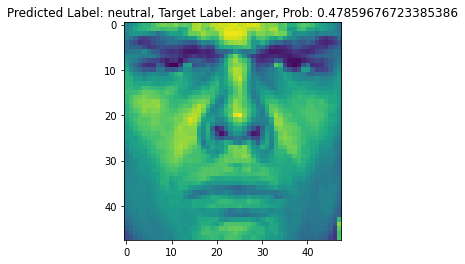

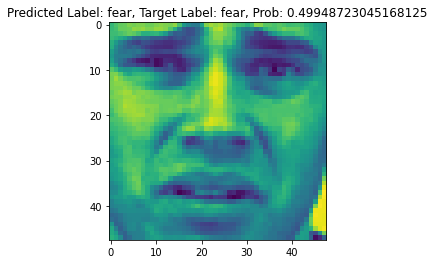

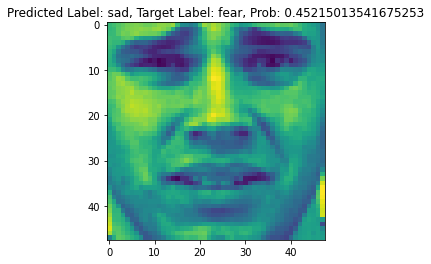

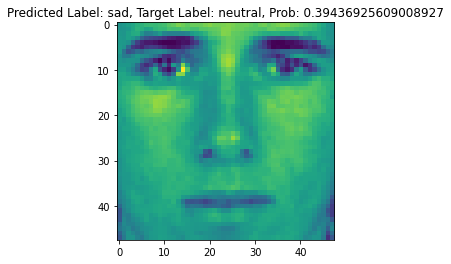

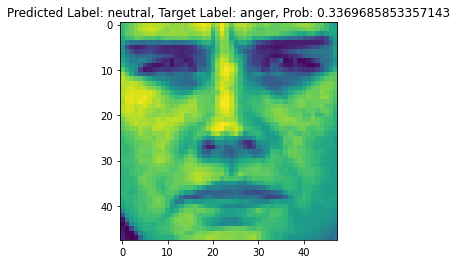

In [25]:
# Plot 5 uncertain images
plot_uncertain(inputs_test, target_test, default_model, 0.5)

We plotted 5 images where the default model has low probability of target being the predicted label (printed as "Prob").

The classifiers will not be accurate when predicting top scoring class.

Most errors are from classes "Sad" and "Anger". For us human, it is easy to mix up these feelings and, hence it is sometimes even challenging for us to correctly identify the labels of these expressions. Neural networks still have quite a lot of features to learn, and they will not predict top scoring class correctly if no more feature learning are introduced.